# Tooth and Cavity Instance Segmentation
Deep learning in dentistry holds a multitude of applications for identifying various dental conditions and diseases. Here, we train a deep-learning model for identifying and segmenting instances of the following:
- Caries
- Cavities
- Teeth
- Cracks

**Instance Segmentation** requires a model to not only create an image mask to classify objects pixel-by-pixel, but also to create boundaries to separate multiple instances of the same object. While multiple architectures are available for performing instance segmentation, we focus on training and comparing the following models:
- Mask RCNN
- YOLOv8

## Setup
Let's begin by importing necessary modules, set up some commonly used paths, and ingest our data. This data comes courtesy of Arab Academy on Roboflow:
- https://universe.roboflow.com/arab-academy-vf9su/dental-7yegp

In [1]:
import numpy as np
import cv2 as cv

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import ReduceLROnPlateau

import torchvision
torchvision.disable_beta_transforms_warning()

from torchvision import models, datasets
from torchvision.datasets import (
    CocoDetection,
    wrap_dataset_for_transforms_v2
)
from torchvision.transforms import v2

from types import SimpleNamespace
from pathlib import Path
from pprint import pprint
from typing import Optional, Tuple, Dict, Any
from collections import defaultdict
from tqdm.cli import tqdm

import sys, os
# go up one folder from notebooks/ to project root
sys.path.append(os.path.abspath(".."))


In [2]:
import sys
sys.path.append("../src/")

from mask_rcnn_model import MaskRCNNTrainer
from visualization_utils import (
    plot_coco_image,
    plot_coco_image_prediction,
    plot_coco_image_predictions,
)
from mask_rcnn_utils import (
    get_cocodetection_dataset,
    custom_collate_function,
    process_output,
    process_outputs,
    CATEGORY_ID_TO_NAME
)

from metric_utils import (
    mask_iou_matrix,
    match_predicted_and_true_masks,
    evaluate_instance_segmentation,
    evaluate_instance_segmentation_multiple_thresholds
)

e:\CV_PRO\Tooth-and-Cavity-Instance-Segmentation\.venv\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [3]:
%load_ext tensorboard

In [4]:
FPATHS = SimpleNamespace()
FPATHS.data = Path("../data/")

FPATHS.data_train = FPATHS.data / "train"
FPATHS.data_valid = FPATHS.data / "valid"
FPATHS.data_test = FPATHS.data / "test"

FPATHS.data_annotations_fname = "_annotations.coco.json"
FPATHS.data_train_annotations = FPATHS.data_train / FPATHS.data_annotations_fname
FPATHS.data_valid_annotations = FPATHS.data_valid / FPATHS.data_annotations_fname
FPATHS.data_test_annotations = FPATHS.data_test / FPATHS.data_annotations_fname

FPATHS.models = Path("../models/mask_rcnn/")
FPATHS.logs = Path("../logs/mask_rcnn")

In [5]:
MODEL_NAME = "maskrcnn_resnet50_fpn_v2"
MAX_EPOCHS = 100

# Memory constraints limits us to only 2 observations/batch (8GB VRAM)
BATCH_SIZE = 8

# (<inf For Testing purposes) - only run these number of batches in training dataset
MAX_BATCHES_TRAIN = np.inf
MAX_BATCHES_VALID = np.inf
# MAX_BATCHES_TRAIN = 16
# MAX_BATCHES_VALID = MAX_BATCHES_TRAIN // 3

LEARNING_RATE = 1e-3
EARLY_STOP_PATIENCE = 5

# Learning rate schedule parameters (Reduce LR on Plateau)
LR_SCHEDULER_FACTOR = 0.1
LR_SCHEDULER_PATIENCE = 3

# How many batches to run through before logging our metrics
LOG_BATCH_INTERVAL = 128
LOG_VALID_IMAGES = BATCH_SIZE

assert LOG_VALID_IMAGES <= BATCH_SIZE and LOG_VALID_IMAGES >= 0, (
    "LOG_VALID_IMAGES must be non-negative and not larger than BATCH_SIZE"
)


print(f"""
Model Training 
- Model:                   {MODEL_NAME}
- Initial Learning Rate:   {LEARNING_RATE}
- Max Epochs:              {MAX_EPOCHS}
- Ealy Stop Patience:      {EARLY_STOP_PATIENCE}

Data Loading
- Batch Size:              {BATCH_SIZE}
- Maximum Batches (Train): {MAX_BATCHES_TRAIN}
- Maximum Batches (Valid): {MAX_BATCHES_VALID}

Logging
- Log Batch Interval:      {LOG_BATCH_INTERVAL} (Based on Effective Batch Size)
- Log Validation Images:   {LOG_VALID_IMAGES} (# Of Validation Images to Display)
""")


Model Training 
- Model:                   maskrcnn_resnet50_fpn_v2
- Initial Learning Rate:   0.001
- Max Epochs:              100
- Ealy Stop Patience:      5

Data Loading
- Batch Size:              8
- Maximum Batches (Train): inf
- Maximum Batches (Valid): inf

Logging
- Log Batch Interval:      128 (Based on Effective Batch Size)
- Log Validation Images:   8 (# Of Validation Images to Display)



### Defining Augmentations and Train/Val/Test Datasets
Since data provides bounding boxes, masks, and segmentations in the [COCO format](https://cocodataset.org/#home), we can utilize `torchvision.datasets.CocoDetection` class to help load the data in as a PyTorch Dataset.

We also define the augmentations to integrate with our training observations.

In [6]:
datasets = SimpleNamespace()
datasets.train = get_cocodetection_dataset(FPATHS.data_train, FPATHS.data_train_annotations, True)
datasets.valid = get_cocodetection_dataset(FPATHS.data_valid, FPATHS.data_valid_annotations, False)
datasets.test = get_cocodetection_dataset(FPATHS.data_test, FPATHS.data_test_annotations, False)

loading annotations into memory...
Done (t=1.07s)
creating index...
index created!
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


### Visualizing Instances
Let's build out some functionality to visualize the bounding boxes, masks, and segmentations of each observation. We define `plot_coco_image()` for this purpose.

{'boxes': BoundingBoxes([[  5.0000,  57.0000, 204.7290, 329.1760],
               [177.0000, 126.0000, 285.7300, 388.8170],
               [193.0000, 189.0000, 228.7620, 139.9280],
               [ 33.0000, 185.0000, 123.7270, 113.5480]], format=BoundingBoxFormat.XYWH, canvas_size=(640, 640)), 'labels': tensor([4, 4, 2, 2]), 'masks': Mask([[[0, 0, 0,  ..., 0, 0, 0],
       [0, 0, 0,  ..., 0, 0, 0],
       [0, 0, 0,  ..., 0, 0, 0],
       ...,
       [0, 0, 0,  ..., 0, 0, 0],
       [0, 0, 0,  ..., 0, 0, 0],
       [0, 0, 0,  ..., 0, 0, 0]],

      [[0, 0, 0,  ..., 0, 0, 0],
       [0, 0, 0,  ..., 0, 0, 0],
       [0, 0, 0,  ..., 0, 0, 0],
       ...,
       [0, 0, 0,  ..., 0, 0, 0],
       [0, 0, 0,  ..., 0, 0, 0],
       [0, 0, 0,  ..., 0, 0, 0]],

      [[0, 0, 0,  ..., 0, 0, 0],
       [0, 0, 0,  ..., 0, 0, 0],
       [0, 0, 0,  ..., 0, 0, 0],
       ...,
       [0, 0, 0,  ..., 0, 0, 0],
       [0, 0, 0,  ..., 0, 0, 0],
       [0, 0, 0,  ..., 0, 0, 0]],

      [[0, 0, 0,  ..., 0, 0,

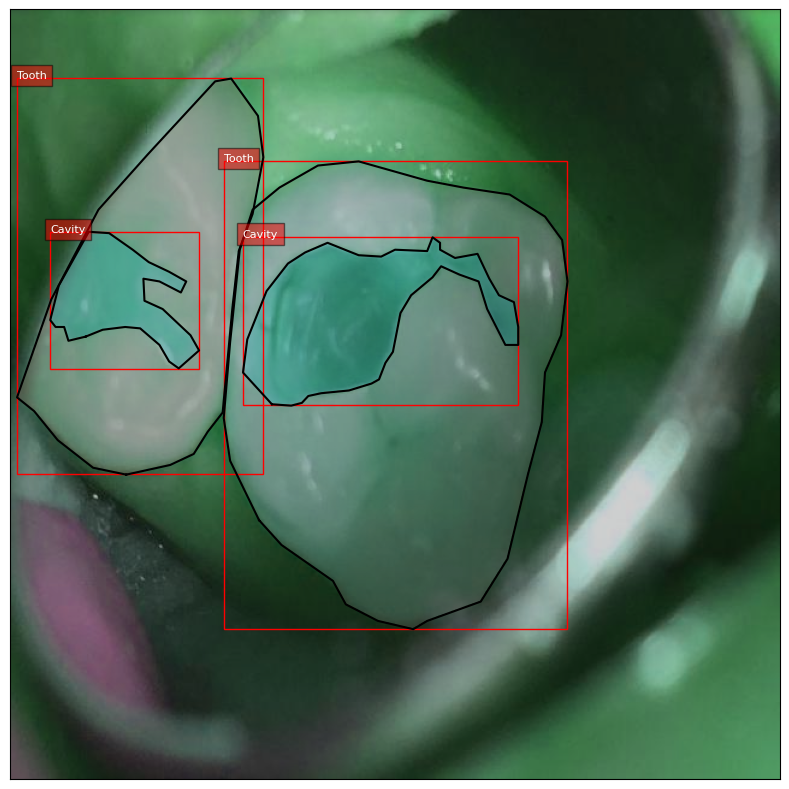

In [7]:
image, target = datasets.train[1]
print(target)
coco_image_example = plot_coco_image(
    image,
    target,
    plot_masks=True,
    plot_bboxes=True,
    plot_segmentations=True,
    plot_category_id=True,
    category_names=CATEGORY_ID_TO_NAME,
)

### Creating a PyTorch `DataLoader`
Dataloader's help us retrieve a batch of training samples for more seamless model training training. Since PyTorch expects each batch to be constant, we have to update our `collate_fn`. We define `custom_collate_function()` to represent each batch as a tuple `(images, targets)`. To ensure we can run the network on our GPU, we also have to move the images and certain targets to the GPU.

Here, we can the structure of each batch:

```python
# Start iterating through the dataloader
images, targets = next(iter(dataloader))

# Extracts the first instance in the batch
image = images[0]
target = targets[0]

# Access the data in the target
target_bboxes = target["bbox"]
target_areas = target["area"]
target_segmentation = target["segmentation"]
```

In [8]:
dataloaders = SimpleNamespace()
dataloaders.train = DataLoader(
    datasets.train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=custom_collate_function
)

dataloaders.valid = DataLoader(
    datasets.valid,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=custom_collate_function
)

dataloaders.test = DataLoader(
    datasets.test,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=custom_collate_function
)

In [9]:
from src.dataset import COCODataset, get_transform
from src.mask_rcnn_model import MaskRCNNTrainer


train_dataset = COCODataset(
    root="../data/train",
    annFile="../data/train/_annotations.coco.json",  # adjust filename
    transforms=get_transform(train=True)
)

valid_dataset = COCODataset(
    root="../data/valid",
    annFile="../data/valid/_annotations.coco.json",  # adjust filename
    transforms=get_transform(train=False)
)

dataloaders = {
    "train": DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x))),
    "valid": DataLoader(valid_dataset, batch_size=2, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))
}


In [10]:
import torch
print(torch.cuda.is_available())  # should be True
print(torch.version.cuda)



True
12.1


In [11]:
# Set to `True` if we want to train the model;
# Otherwise skip and use previously-stored model checkpoints
train_model = False

if train_model:
    mask_rcnn = models.get_model(
        MODEL_NAME,
        weights=models.detection.MaskRCNN_ResNet50_FPN_V2_Weights.COCO_V1,
        weights_backbone=models.ResNet50_Weights.IMAGENET1K_V2,
        trainable_backbone_layers=2
    )
    
    mask_rcnn.cuda()
    
    mask_rcnn_trainer = MaskRCNNTrainer(
        mask_rcnn,
        dataloaders["train"],
        dataloaders["valid"],
        learning_rate=LEARNING_RATE,
        scheduler_factor=LR_SCHEDULER_FACTOR,
        scheduler_patience=LR_SCHEDULER_PATIENCE,
        early_stop_patience=EARLY_STOP_PATIENCE,
        log_batches_interval=LOG_BATCH_INTERVAL,
        fpath_logs=FPATHS.logs,
        fpath_models=FPATHS.models,
        max_batches_train=MAX_BATCHES_TRAIN,
        max_batches_valid=MAX_BATCHES_VALID
    )
    
    mask_rcnn_trainer.train(MAX_EPOCHS)

## Explore Model Checkpoints

In [12]:
import os
print(os.getcwd())

e:\CV_PRO\Tooth-and-Cavity-Instance-Segmentation\notebooks


In [13]:
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau
from pathlib import Path
# Path to your model checkpoint E:\CV_PRO\Tooth-and-Cavity-Instance-Segmentation\models\mask_rcnn\final_model_checkpoint_epoch_27.pth
checkpoint_path = Path("../models/mask_rcnn/final_model_checkpoint_epoch_27.pth")

# Load checkpoint
checkpoint = torch.load(checkpoint_path, map_location="cuda")
if isinstance(checkpoint, dict):
    print("Keys in checkpoint:", checkpoint.keys())
else:
    print("Checkpoint type:", type(checkpoint))

#print(checkpoint)
# Rebuild model
model = models.get_model(MODEL_NAME, weights=None, weights_backbone=None)
model.load_state_dict(checkpoint["model_state_dict"])
model = model.cuda().eval()

# # Rebuild optimizer
optimizer = torch.optim.Adam(model.parameters())
# optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

# # Rebuild scheduler
# scheduler = ReduceLROnPlateau(optimizer)

# scheduler.load_state_dict(checkpoint["scheduler_state_dict"])



C:\Users\Admin\AppData\Local\Temp\ipykernel_591960\3811518725.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location="cuda

Keys in checkpoint: dict_keys(['epoch', 'valid_loss', 'model_state_dict', 'optimizer_state_dict', 'scheduler_state_dict'])


In [14]:
from pathlib import Path

FPATHS.model_checkpoints = list(FPATHS.models.glob("*.pth"))

ckpt_path = FPATHS.model_checkpoints[1]   # now indexing works
checkpoint = torch.load(ckpt_path, map_location="cpu")

if isinstance(checkpoint, dict):
    print("Keys in checkpoint:", checkpoint.keys())
else:
    print("Checkpoint type:", type(checkpoint))


Keys in checkpoint: dict_keys(['epoch', 'valid_loss', 'model_state_dict', 'optimizer_state_dict', 'scheduler_state_dict'])


C:\Users\Admin\AppData\Local\Temp\ipykernel_591960\534901122.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ckpt_path, map_location="cpu")


In [15]:
# Use the best model checkpoint (lowest valid_loss) from your own training runs
FPATHS.model_checkpoints = list(FPATHS.models.glob("*.pth"))

# Load only checkpoints that have "valid_loss"
valid_checkpoints = []
for path in FPATHS.model_checkpoints:
    chkpt = torch.load(path, map_location="cpu")
    if "valid_loss" in chkpt:   # ✅ skip torchvision pre-trained weights
        valid_checkpoints.append((chkpt, path))

if not valid_checkpoints:
    raise RuntimeError("No valid training checkpoints found. Did you train the model?")

# Select best checkpoint based on validation loss
checkpoint, checkpoint_path = min(valid_checkpoints, key=lambda x: x[0]["valid_loss"])
print(f"Loaded best checkpoint from: {checkpoint_path}, valid_loss={checkpoint['valid_loss']:.4f}")

# Load the model
model = models.get_model(MODEL_NAME, weights=None, weights_backbone=None)
model.load_state_dict(checkpoint["model_state_dict"])   # ✅ use your checkpoint, not COCO weights
model.to("cuda" if torch.cuda.is_available() else "cpu")
model.eval()

# Load optimizer + scheduler state
optimizer = torch.optim.Adam(model.parameters())
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

scheduler = ReduceLROnPlateau(optimizer)
scheduler.load_state_dict(checkpoint["scheduler_state_dict"])


C:\Users\Admin\AppData\Local\Temp\ipykernel_591960\4181360331.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  chkpt = torch.load(path, map_location="cpu")


Loaded best checkpoint from: ..\models\mask_rcnn\model_checkpoint_epoch_22.pth, valid_loss=0.7316


In [16]:
from torch.utils.data import DataLoader
from src.dataset import COCODataset, get_transform

train_dataset = COCODataset(
    root="../data/train",
    annFile="../data/train/_annotations.coco.json",
    transforms=get_transform(train=True)
)

valid_dataset = COCODataset(
    root="../data/valid",
    annFile="../data/valid/_annotations.coco.json",
    transforms=get_transform(train=False)
)

test_dataset = COCODataset(
    root="../data/test",
    annFile="../data/test/_annotations.coco.json",
    transforms=get_transform(train=False)
)

dataloaders = {
    "train": DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x))),
    "valid": DataLoader(valid_dataset, batch_size=2, shuffle=False, collate_fn=lambda x: tuple(zip(*x))),
    "test":  DataLoader(test_dataset,  batch_size=2, shuffle=False, collate_fn=lambda x: tuple(zip(*x))),
}


dict_keys(['boxes', 'labels', 'scores', 'masks'])


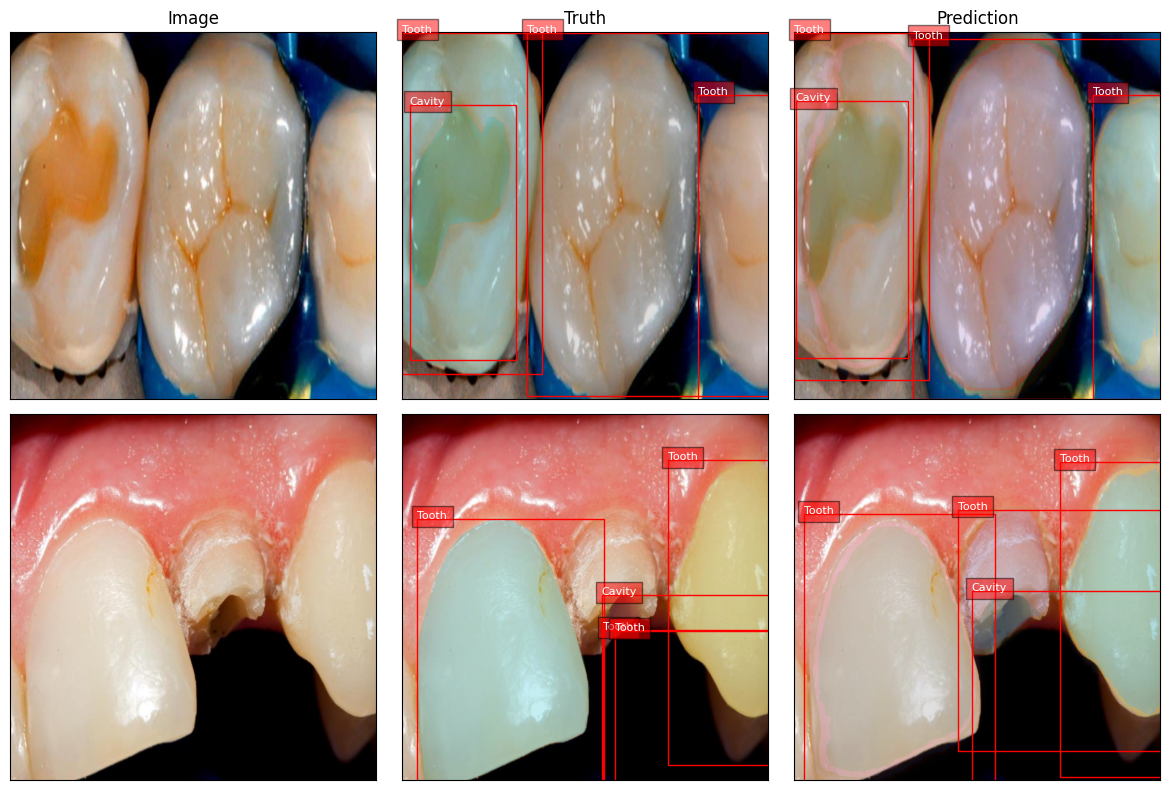

In [17]:
from typing import Dict, Any
import torch

# --- helper ---
def move_tensors_in_dict_to_cpu(d: Dict[Any, Any]) -> Dict[Any, Any]:
    return {k: (v.cpu() if isinstance(v, torch.Tensor) else v) for k, v in d.items()}

# --- 1. Get batch ---
images, targets = next(iter(dataloaders["test"]))

# --- 2. Move to device ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
images = [img.to(device) for img in images]
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

# --- 3. Forward pass ---
with torch.no_grad():
    outputs = model(images)

# --- 4. Move outputs to CPU ---
outputs = [
    {k: (v.detach().cpu() if isinstance(v, torch.Tensor) else v) for k, v in t.items()}
    for t in outputs
]
print(outputs[0].keys())
# --- 5. Move to CPU & plot ---
image_array_fig = plot_coco_image_predictions(
    [img.cpu() for img in images],
    outputs,
    [move_tensors_in_dict_to_cpu(target) for target in targets],
    category_names=CATEGORY_ID_TO_NAME
)


In [18]:
print(targets[0].keys())
print(targets[0])

dict_keys(['boxes', 'labels', 'masks', 'image_id', 'area', 'iscrowd'])
{'boxes': tensor([[517.0000, 109.0000, 639.5000, 627.6210],
        [218.0000,   0.0000, 519.2500, 634.4830],
        [ 13.0000, 126.0000, 186.1250, 446.0000],
        [  0.0000,   0.0000, 243.7500, 597.2410]], device='cuda:0'), 'labels': tensor([4, 4, 2, 4], device='cuda:0'), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
 

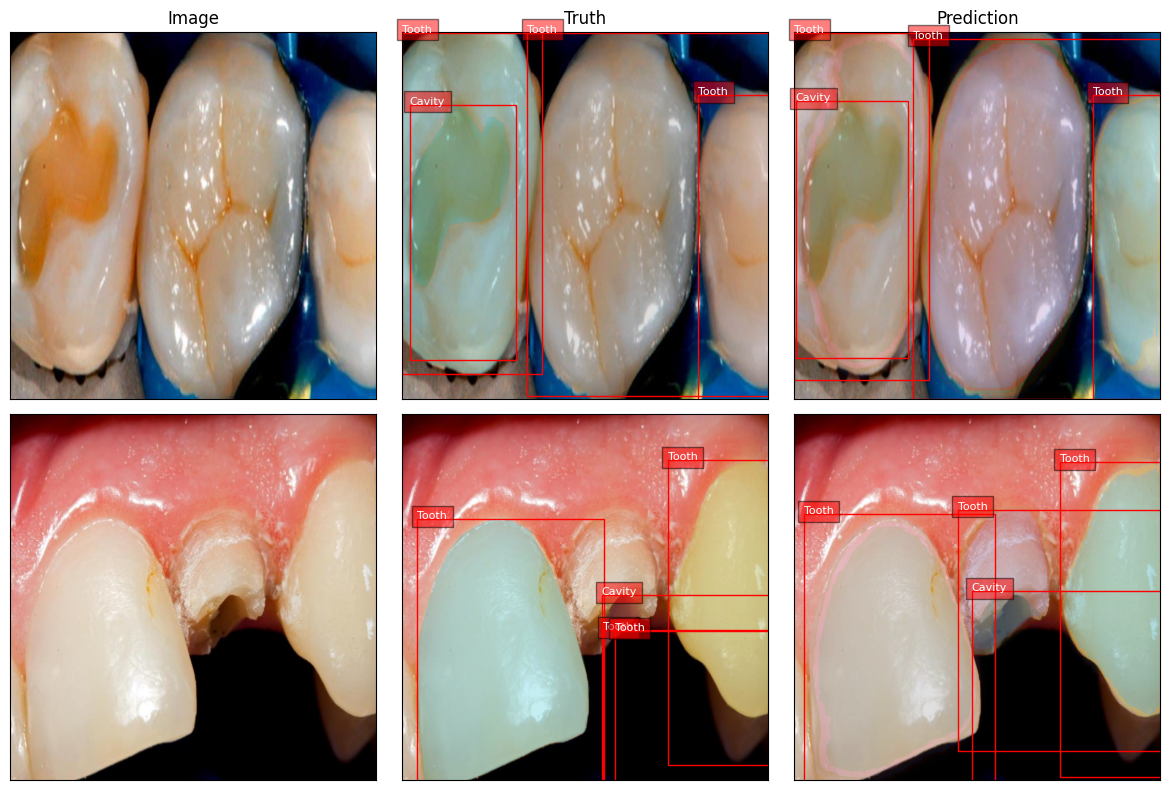

In [19]:
from typing import Dict, Any
import torch
import sys

# if running from notebooks/, make sure src is discoverable
sys.path.append("../src")

from visualization_utils import plot_coco_image_predictions

def move_tensors_in_dict_to_cpu(d: Dict[Any, Any]) -> Dict[Any, Any]:
    for key, val in d.items():
        if isinstance(val, torch.Tensor):
            d[key] = val.cpu()
    return d

# call visualization
image_array_fig = plot_coco_image_predictions(
    [img.cpu() for img in images],   
    outputs,
    [move_tensors_in_dict_to_cpu(target) for target in targets],  
    category_names=CATEGORY_ID_TO_NAME
)


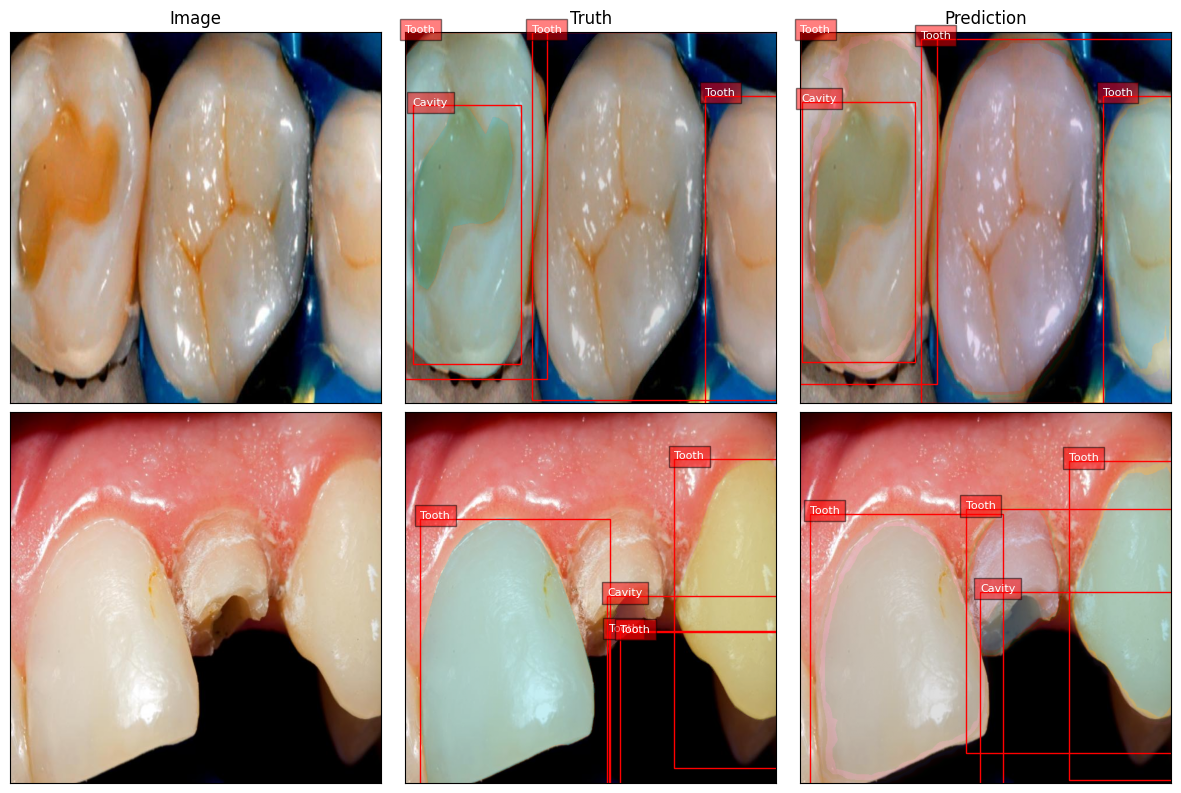

In [20]:
from torchvision.ops import box_convert

# ✅ Convert ground truth targets to include "bbox" (XYWH format)
targets_cpu = []
for t in targets:
    t_cpu = move_tensors_in_dict_to_cpu(t)
    if "boxes" in t_cpu:
        t_cpu["bbox"] = box_convert(t_cpu["boxes"], in_fmt="xyxy", out_fmt="xywh")
    targets_cpu.append(t_cpu)

# ✅ Predictions already have "bbox"
outputs_cpu = [move_tensors_in_dict_to_cpu(o) for o in outputs]

# ✅ Images as batched tensor
images_cpu = torch.stack([img.cpu() for img in images])

# ✅ Plot (bbox-only, since no masks in your dataset)
image_array_fig = plot_coco_image_predictions(
    images_cpu,
    outputs_cpu,
    targets_cpu,
    category_names=CATEGORY_ID_TO_NAME
)
plt.show()



In [21]:
# Evaluate metrics at IoU threshold = 0.5
iou_threshold = 0.7
metrics = evaluate_instance_segmentation(
    model,
    dataloaders["test"],   # ✅ use dict key access
    iou_threshold=iou_threshold
)

display(metrics)


Evaluating:   1%|          | 1/125 [00:00<00:54,  2.26it/s, Precision=0.545, Recall=0.667, F1-Score=0.600]

[4, 4, 4, 2, 4]
[4, 4, 4, 2, 4, 4]


Evaluating:   2%|▏         | 2/125 [00:00<00:43,  2.86it/s, Precision=0.763, Recall=0.829, F1-Score=0.795]

[4, 4, 4, 4, 4, 4, 1]
[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]


Evaluating:   2%|▏         | 3/125 [00:01<00:39,  3.11it/s, Precision=0.733, Recall=0.759, F1-Score=0.746]

[4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 2, 2]
[4, 4, 4, 1, 1, 1, 4, 1]


Evaluating:   3%|▎         | 4/125 [00:01<00:34,  3.48it/s, Precision=0.711, Recall=0.740, F1-Score=0.725]

[4, 4, 2, 4, 1, 1, 4, 1, 4]
[4, 4, 4, 4, 4, 4, 4]


Evaluating:   4%|▍         | 5/125 [00:01<00:32,  3.71it/s, Precision=0.713, Recall=0.744, F1-Score=0.728]

[4, 4, 4, 4, 4, 4, 4, 4]
[4, 4, 4, 4, 4, 1, 4, 4, 4, 4]


Evaluating:   5%|▍         | 6/125 [00:01<00:31,  3.81it/s, Precision=0.750, Recall=0.757, F1-Score=0.753]

[4, 4, 4, 4, 4, 2]
[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]


Evaluating:   6%|▌         | 7/125 [00:02<00:34,  3.43it/s, Precision=0.747, Recall=0.799, F1-Score=0.772]

[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1]
[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]


Evaluating:   6%|▋         | 8/125 [00:02<00:32,  3.62it/s, Precision=0.722, Recall=0.782, F1-Score=0.751]

[4, 4, 4, 4, 3]
[4, 4, 4, 4, 4, 2, 4, 4, 4, 4]


Evaluating:   7%|▋         | 9/125 [00:02<00:32,  3.61it/s, Precision=0.710, Recall=0.770, F1-Score=0.739]

[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
[4, 4, 4, 2, 4, 4, 2, 4, 4, 4, 2, 4, 2]


Evaluating:   8%|▊         | 10/125 [00:02<00:31,  3.61it/s, Precision=0.727, Recall=0.785, F1-Score=0.755]

[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
[4, 4, 4, 4, 2, 1, 4, 2]


Evaluating:   9%|▉         | 11/125 [00:03<00:30,  3.74it/s, Precision=0.725, Recall=0.786, F1-Score=0.754]

[4, 4, 4, 2, 1, 1, 2, 4]
[4, 4, 4, 4, 4, 4, 4, 4, 4]


Evaluating:  10%|▉         | 12/125 [00:03<00:30,  3.76it/s, Precision=0.720, Recall=0.792, F1-Score=0.755]

[4, 4, 1, 1, 4, 2]
[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4]


Evaluating:  10%|█         | 13/125 [00:03<00:31,  3.59it/s, Precision=0.721, Recall=0.793, F1-Score=0.755]

[4, 4, 4, 4, 2, 2, 1, 4, 4, 2, 2, 1, 1]
[4, 4, 4, 4, 4, 4, 4, 4, 4]


Evaluating:  11%|█         | 14/125 [00:03<00:30,  3.66it/s, Precision=0.732, Recall=0.807, F1-Score=0.768]

[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1]
[4, 4, 4, 4, 4]


Evaluating:  12%|█▏        | 15/125 [00:04<00:30,  3.60it/s, Precision=0.748, Recall=0.820, F1-Score=0.782]

[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
[4, 4, 1, 2, 4]


Evaluating:  13%|█▎        | 16/125 [00:04<00:30,  3.61it/s, Precision=0.741, Recall=0.822, F1-Score=0.779]

[2, 4, 4]
[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]


Evaluating:  14%|█▎        | 17/125 [00:04<00:28,  3.84it/s, Precision=0.737, Recall=0.814, F1-Score=0.774]

[4, 4, 4, 4, 4, 2, 4, 1]
[4, 4, 4, 4, 4, 1]


Evaluating:  14%|█▍        | 18/125 [00:04<00:26,  4.03it/s, Precision=0.739, Recall=0.806, F1-Score=0.771]

[4, 4, 4, 4, 4, 4, 4]
[4, 4, 4, 4, 4, 4, 4]


Evaluating:  15%|█▌        | 19/125 [00:05<00:25,  4.20it/s, Precision=0.739, Recall=0.792, F1-Score=0.765]

[4, 4, 4, 4]
[4, 4, 4, 2, 1]


Evaluating:  16%|█▌        | 20/125 [00:05<00:26,  3.93it/s, Precision=0.752, Recall=0.801, F1-Score=0.776]

[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
[2, 4, 2]


Evaluating:  17%|█▋        | 21/125 [00:05<00:27,  3.81it/s, Precision=0.742, Recall=0.762, F1-Score=0.752]

[1, 4, 4, 4, 1, 1, 4, 1, 1, 1, 1, 2]
[4, 4, 4, 4, 4, 4]


Evaluating:  18%|█▊        | 22/125 [00:06<00:26,  3.84it/s, Precision=0.744, Recall=0.740, F1-Score=0.742]

[4, 4, 4, 4, 4, 1, 4, 4, 4, 4]
[4, 4, 4, 4, 2]


Evaluating:  18%|█▊        | 23/125 [00:06<00:29,  3.47it/s, Precision=0.729, Recall=0.735, F1-Score=0.732]

[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 2, 1, 4, 2]
[4, 4, 4, 1, 1, 1, 1, 4, 1, 1, 1, 4, 1, 1, 1, 1]


Evaluating:  19%|█▉        | 24/125 [00:06<00:28,  3.60it/s, Precision=0.736, Recall=0.740, F1-Score=0.738]

[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
[4, 4, 4, 4, 4]


Evaluating:  20%|██        | 25/125 [00:06<00:26,  3.79it/s, Precision=0.738, Recall=0.742, F1-Score=0.740]

[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
[4, 4, 1]


Evaluating:  21%|██        | 26/125 [00:07<00:25,  3.88it/s, Precision=0.743, Recall=0.744, F1-Score=0.744]

[4, 4, 4, 4]
[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4]


Evaluating:  22%|██▏       | 27/125 [00:07<00:25,  3.89it/s, Precision=0.745, Recall=0.750, F1-Score=0.747]

[4, 4, 4, 4]
[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]


Evaluating:  22%|██▏       | 28/125 [00:07<00:25,  3.73it/s, Precision=0.739, Recall=0.745, F1-Score=0.742]

[4, 4, 4, 4, 4, 4, 4, 1, 1, 1, 1, 4, 4, 4]
[4, 4, 4, 4, 4, 2, 1, 1, 1, 4]


Evaluating:  23%|██▎       | 29/125 [00:07<00:26,  3.65it/s, Precision=0.747, Recall=0.747, F1-Score=0.747]

[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1]
[4, 4, 4, 4, 4, 4, 4, 4, 4]


Evaluating:  24%|██▍       | 30/125 [00:08<00:24,  3.91it/s, Precision=0.748, Recall=0.749, F1-Score=0.749]

[4, 4, 4, 4, 4, 4, 3]
[4, 4, 4, 4, 4, 1]


Evaluating:  25%|██▍       | 31/125 [00:08<00:24,  3.86it/s, Precision=0.745, Recall=0.752, F1-Score=0.749]

[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 4]
[4, 4, 4, 4, 4, 4, 4]


Evaluating:  26%|██▌       | 32/125 [00:08<00:24,  3.76it/s, Precision=0.742, Recall=0.749, F1-Score=0.746]

[4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 1, 1]
[4, 4, 1, 4, 4, 4]


Evaluating:  26%|██▋       | 33/125 [00:09<00:27,  3.38it/s, Precision=0.739, Recall=0.748, F1-Score=0.744]

[4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 1, 1, 4, 4, 1, 1, 1]
[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]


Evaluating:  27%|██▋       | 34/125 [00:09<00:26,  3.43it/s, Precision=0.737, Recall=0.756, F1-Score=0.746]

[4, 4, 4, 4, 4, 4, 1, 4, 4, 1]
[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]


Evaluating:  28%|██▊       | 35/125 [00:09<00:28,  3.12it/s, Precision=0.745, Recall=0.747, F1-Score=0.746]

[4, 4, 4, 1]
[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]


Evaluating:  29%|██▉       | 36/125 [00:09<00:26,  3.33it/s, Precision=0.742, Recall=0.748, F1-Score=0.745]

[4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
[4, 4, 4, 2, 4, 4, 1, 4, 2, 1]


Evaluating:  30%|██▉       | 37/125 [00:10<00:26,  3.27it/s, Precision=0.730, Recall=0.737, F1-Score=0.734]

[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 2, 4, 2, 4, 1, 2]
[4, 4, 4, 1, 4, 1, 1, 4]


Evaluating:  30%|███       | 38/125 [00:10<00:25,  3.39it/s, Precision=0.733, Recall=0.738, F1-Score=0.735]

[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
[4, 4, 4, 1, 2, 1, 4]


Evaluating:  31%|███       | 39/125 [00:10<00:24,  3.47it/s, Precision=0.734, Recall=0.743, F1-Score=0.739]

[4, 4, 4, 4, 4, 4, 4]
[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]


Evaluating:  32%|███▏      | 40/125 [00:11<00:24,  3.50it/s, Precision=0.731, Recall=0.739, F1-Score=0.735]

[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 1, 1]
[4, 4, 1, 4, 4, 4, 2, 1]


Evaluating:  33%|███▎      | 41/125 [00:11<00:21,  3.86it/s, Precision=0.726, Recall=0.741, F1-Score=0.733]

[4, 4]
[4, 4, 4, 4, 4, 2, 4, 4, 4, 4]


Evaluating:  34%|███▎      | 42/125 [00:11<00:21,  3.82it/s, Precision=0.725, Recall=0.739, F1-Score=0.732]

[4, 1, 4, 4, 1]
[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]


Evaluating:  34%|███▍      | 43/125 [00:11<00:22,  3.65it/s, Precision=0.729, Recall=0.743, F1-Score=0.736]

[4, 4, 4, 4, 4, 2, 1, 1, 4, 4]
[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]


Evaluating:  35%|███▌      | 44/125 [00:12<00:24,  3.32it/s, Precision=0.725, Recall=0.748, F1-Score=0.736]

[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 1, 4, 1, 4, 4, 2, 1, 1, 1, 1, 4]
[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]


Evaluating:  36%|███▌      | 45/125 [00:12<00:25,  3.12it/s, Precision=0.731, Recall=0.757, F1-Score=0.744]

[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]


Evaluating:  37%|███▋      | 46/125 [00:12<00:23,  3.29it/s, Precision=0.728, Recall=0.758, F1-Score=0.743]

[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
[4, 4, 4, 1, 4, 1, 1, 4, 1]


Evaluating:  38%|███▊      | 47/125 [00:13<00:22,  3.43it/s, Precision=0.727, Recall=0.756, F1-Score=0.741]

[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
[4, 4, 4, 4, 2, 4, 4, 4, 1]


Evaluating:  38%|███▊      | 48/125 [00:13<00:21,  3.59it/s, Precision=0.726, Recall=0.754, F1-Score=0.740]

[4, 4, 1, 4, 2, 2]
[4, 4, 4, 4, 2, 1, 4, 1]


Evaluating:  39%|███▉      | 49/125 [00:13<00:21,  3.52it/s, Precision=0.729, Recall=0.754, F1-Score=0.741]

[4, 4, 1, 4, 1, 4, 1, 4, 2, 1]
[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]


Evaluating:  40%|████      | 50/125 [00:13<00:19,  3.87it/s, Precision=0.728, Recall=0.753, F1-Score=0.740]

[4, 4, 4]
[4, 4, 4, 4, 4]
[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
[4, 4, 2, 2]


Evaluating:  42%|████▏     | 52/125 [00:14<00:19,  3.66it/s, Precision=0.729, Recall=0.760, F1-Score=0.744]

[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4]
[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2]


Evaluating:  42%|████▏     | 53/125 [00:14<00:20,  3.45it/s, Precision=0.719, Recall=0.755, F1-Score=0.737]

[4, 4, 4, 4, 4, 4, 2, 1, 4, 1, 4, 4, 2, 4, 2, 4, 2]
[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]


Evaluating:  43%|████▎     | 54/125 [00:15<00:20,  3.54it/s, Precision=0.723, Recall=0.759, F1-Score=0.740]

[4, 4, 4, 4, 4]
[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]


Evaluating:  44%|████▍     | 55/125 [00:15<00:18,  3.78it/s, Precision=0.722, Recall=0.760, F1-Score=0.741]

[4, 4, 4, 4, 4, 4, 4]
[4, 4, 4, 2, 1, 4]
[4, 4, 1, 2, 1]
[4, 4, 4, 4, 4, 4, 4]


Evaluating:  46%|████▌     | 57/125 [00:15<00:18,  3.69it/s, Precision=0.726, Recall=0.761, F1-Score=0.743]

[4, 4, 2, 1]
[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]


Evaluating:  46%|████▋     | 58/125 [00:16<00:19,  3.47it/s, Precision=0.730, Recall=0.767, F1-Score=0.748]

[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]


Evaluating:  47%|████▋     | 59/125 [00:16<00:18,  3.65it/s, Precision=0.728, Recall=0.769, F1-Score=0.748]

[4, 4, 4, 3, 1, 4]
[4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 3]


Evaluating:  48%|████▊     | 60/125 [00:16<00:17,  3.75it/s, Precision=0.729, Recall=0.767, F1-Score=0.747]

[4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4]
[4, 4, 4, 1, 4, 1, 1, 2]


Evaluating:  49%|████▉     | 61/125 [00:16<00:18,  3.47it/s, Precision=0.725, Recall=0.766, F1-Score=0.745]

[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 2, 2, 4]
[4, 4, 1, 4, 4, 4, 4, 4, 4, 2, 1, 4, 4]


Evaluating:  50%|████▉     | 62/125 [00:17<00:18,  3.48it/s, Precision=0.724, Recall=0.763, F1-Score=0.743]

[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4]
[4, 2, 4, 4, 4, 4]


Evaluating:  50%|█████     | 63/125 [00:17<00:19,  3.21it/s, Precision=0.730, Recall=0.766, F1-Score=0.748]

[4, 4, 4, 4, 4, 4, 4, 4, 4]
[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]


Evaluating:  51%|█████     | 64/125 [00:17<00:18,  3.37it/s, Precision=0.731, Recall=0.767, F1-Score=0.748]

[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
[4, 4, 4, 4, 1, 1, 1]


Evaluating:  52%|█████▏    | 65/125 [00:18<00:17,  3.38it/s, Precision=0.732, Recall=0.766, F1-Score=0.748]

[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]


Evaluating:  53%|█████▎    | 66/125 [00:18<00:16,  3.49it/s, Precision=0.732, Recall=0.767, F1-Score=0.749]

[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 1]
[4, 2, 4, 1, 1, 4, 1, 1, 1]


Evaluating:  54%|█████▎    | 67/125 [00:18<00:15,  3.69it/s, Precision=0.734, Recall=0.769, F1-Score=0.751]

[4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
[4, 4, 4, 4, 4, 4, 4, 4]


Evaluating:  54%|█████▍    | 68/125 [00:18<00:15,  3.74it/s, Precision=0.736, Recall=0.768, F1-Score=0.752]

[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
[4, 4, 4, 2, 4, 4, 1]


Evaluating:  55%|█████▌    | 69/125 [00:19<00:14,  3.74it/s, Precision=0.737, Recall=0.770, F1-Score=0.753]

[4, 4, 4, 4]
[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]


Evaluating:  56%|█████▌    | 70/125 [00:19<00:16,  3.24it/s, Precision=0.737, Recall=0.775, F1-Score=0.756]

[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]


Evaluating:  57%|█████▋    | 71/125 [00:19<00:17,  3.13it/s, Precision=0.738, Recall=0.777, F1-Score=0.757]

[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
[4, 4, 4, 4, 4, 4, 4, 2, 1, 4, 4, 2, 2, 4, 4, 4, 2]


Evaluating:  58%|█████▊    | 72/125 [00:20<00:15,  3.40it/s, Precision=0.737, Recall=0.777, F1-Score=0.756]

[4, 4, 4, 2, 2, 4, 2, 4, 4, 4]
[4, 4, 4, 4, 4, 4, 4, 4, 2]


Evaluating:  58%|█████▊    | 73/125 [00:20<00:16,  3.21it/s, Precision=0.733, Recall=0.775, F1-Score=0.753]

[4, 4, 4, 1, 1, 1, 4, 4, 2]
[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 1, 4, 4, 1, 2, 1, 3, 1, 2, 4]


Evaluating:  59%|█████▉    | 74/125 [00:20<00:16,  3.04it/s, Precision=0.736, Recall=0.776, F1-Score=0.755]

[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1]
[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]


Evaluating:  60%|██████    | 75/125 [00:21<00:16,  3.00it/s, Precision=0.738, Recall=0.775, F1-Score=0.756]

[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 1, 2]


Evaluating:  61%|██████    | 76/125 [00:21<00:14,  3.34it/s, Precision=0.736, Recall=0.775, F1-Score=0.755]

[4, 1, 4, 4, 2, 4]
[4, 4, 1, 4, 4, 4]


Evaluating:  62%|██████▏   | 77/125 [00:21<00:13,  3.45it/s, Precision=0.737, Recall=0.775, F1-Score=0.755]

[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4]
[4, 4, 4, 1]


Evaluating:  62%|██████▏   | 78/125 [00:22<00:13,  3.42it/s, Precision=0.735, Recall=0.776, F1-Score=0.755]

[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
[2, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 2]


Evaluating:  63%|██████▎   | 79/125 [00:22<00:14,  3.22it/s, Precision=0.733, Recall=0.780, F1-Score=0.756]

[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]


Evaluating:  64%|██████▍   | 80/125 [00:22<00:14,  3.20it/s, Precision=0.734, Recall=0.779, F1-Score=0.756]

[4, 4, 4]
[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 1, 1]


Evaluating:  65%|██████▍   | 81/125 [00:22<00:12,  3.47it/s, Precision=0.732, Recall=0.777, F1-Score=0.754]

[3, 1, 4, 4, 4, 1, 1, 4, 4]
[4, 4, 4, 4, 2, 4]


Evaluating:  66%|██████▌   | 82/125 [00:23<00:12,  3.31it/s, Precision=0.732, Recall=0.777, F1-Score=0.754]

[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
[4, 4, 4, 4, 2, 2, 4, 2, 1, 1, 1]


Evaluating:  66%|██████▋   | 83/125 [00:23<00:11,  3.65it/s, Precision=0.730, Recall=0.776, F1-Score=0.752]

[4, 4, 1, 4, 4]
[2, 4, 4, 1]


Evaluating:  67%|██████▋   | 84/125 [00:23<00:11,  3.47it/s, Precision=0.729, Recall=0.772, F1-Score=0.750]

[4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 2, 2, 1, 1, 1, 2]
[4, 4, 2]


Evaluating:  68%|██████▊   | 85/125 [00:24<00:12,  3.13it/s, Precision=0.730, Recall=0.770, F1-Score=0.749]

[4, 4, 4, 4, 4, 4, 4, 1, 1, 4, 4, 2, 1, 4, 4, 1, 1, 1, 2, 2, 4]
[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]


Evaluating:  69%|██████▉   | 86/125 [00:24<00:11,  3.45it/s, Precision=0.729, Recall=0.771, F1-Score=0.749]

[4, 2, 2]
[4, 4, 4, 4, 2, 4, 1, 1]
[4, 4]
[4, 4, 4, 4, 4, 4, 4]


Evaluating:  70%|███████   | 88/125 [00:25<00:11,  3.22it/s, Precision=0.728, Recall=0.767, F1-Score=0.747]

[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 2, 4, 4, 4, 2, 2, 2, 4]
[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 2]


Evaluating:  71%|███████   | 89/125 [00:25<00:10,  3.38it/s, Precision=0.728, Recall=0.768, F1-Score=0.747]

[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
[4, 4, 2, 1, 4, 4, 1]


Evaluating:  72%|███████▏  | 90/125 [00:25<00:10,  3.28it/s, Precision=0.726, Recall=0.765, F1-Score=0.745]

[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 2, 1, 4, 4, 1, 2, 1, 4]
[4, 4, 4, 4, 4, 4, 4, 1, 1]


Evaluating:  73%|███████▎  | 91/125 [00:25<00:09,  3.42it/s, Precision=0.726, Recall=0.767, F1-Score=0.746]

[4, 4, 4, 4, 4, 4, 4, 4]
[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]


Evaluating:  74%|███████▎  | 92/125 [00:26<00:09,  3.42it/s, Precision=0.725, Recall=0.769, F1-Score=0.746]

[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 3, 4, 3, 4, 3]
[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]


Evaluating:  74%|███████▍  | 93/125 [00:26<00:08,  3.60it/s, Precision=0.723, Recall=0.767, F1-Score=0.745]

[4, 4, 4, 2, 4, 2]
[4, 2, 4, 2, 2, 1, 2, 1, 1, 4, 2]


Evaluating:  75%|███████▌  | 94/125 [00:26<00:08,  3.57it/s, Precision=0.725, Recall=0.767, F1-Score=0.745]

[4, 4, 4, 4, 4, 4, 4]
[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]


Evaluating:  76%|███████▌  | 95/125 [00:26<00:08,  3.73it/s, Precision=0.725, Recall=0.768, F1-Score=0.746]

[4, 2, 4, 4, 1, 2, 4, 2]
[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]


Evaluating:  77%|███████▋  | 96/125 [00:27<00:07,  3.84it/s, Precision=0.721, Recall=0.766, F1-Score=0.742]

[4, 4, 4, 1, 1, 4]
[4, 4, 4, 2, 3, 1, 4, 2, 2, 4, 1, 4]


Evaluating:  78%|███████▊  | 97/125 [00:27<00:08,  3.48it/s, Precision=0.725, Recall=0.768, F1-Score=0.746]

[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]


Evaluating:  78%|███████▊  | 98/125 [00:27<00:07,  3.41it/s, Precision=0.725, Recall=0.768, F1-Score=0.746]

[4, 4, 4, 2, 4, 2]
[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2]


Evaluating:  79%|███████▉  | 99/125 [00:28<00:07,  3.33it/s, Precision=0.725, Recall=0.768, F1-Score=0.746]

[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
[4, 4, 4, 1, 1, 4, 4, 1, 4, 1]


Evaluating:  80%|████████  | 100/125 [00:28<00:07,  3.51it/s, Precision=0.725, Recall=0.768, F1-Score=0.746]

[2, 4, 4, 2, 2, 2, 1, 4]
[4, 4, 4, 4, 4, 4, 4, 2, 1]


Evaluating:  81%|████████  | 101/125 [00:28<00:06,  3.81it/s, Precision=0.726, Recall=0.769, F1-Score=0.747]

[4, 4, 4, 4, 4, 4]
[4, 4, 4, 4, 4, 4, 4, 4, 4]


Evaluating:  82%|████████▏ | 102/125 [00:28<00:06,  3.80it/s, Precision=0.727, Recall=0.768, F1-Score=0.747]

[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2]
[4, 4, 4, 4, 4, 4, 4, 4, 1]


Evaluating:  82%|████████▏ | 103/125 [00:29<00:05,  3.67it/s, Precision=0.726, Recall=0.766, F1-Score=0.745]

[4, 4, 4, 4, 4, 4, 4, 1, 1, 1, 2, 2, 2, 2, 2, 1, 1]
[4, 4, 2, 2]


Evaluating:  83%|████████▎ | 104/125 [00:29<00:06,  3.46it/s, Precision=0.722, Recall=0.762, F1-Score=0.741]

[4, 4, 4, 1, 1, 1, 1, 4, 1, 1, 4, 1, 4]
[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1]


Evaluating:  84%|████████▍ | 105/125 [00:29<00:05,  3.67it/s, Precision=0.722, Recall=0.762, F1-Score=0.742]

[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
[4, 1, 4, 1, 1]


Evaluating:  85%|████████▍ | 106/125 [00:30<00:05,  3.61it/s, Precision=0.723, Recall=0.764, F1-Score=0.743]

[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4]


Evaluating:  86%|████████▌ | 107/125 [00:30<00:05,  3.60it/s, Precision=0.723, Recall=0.765, F1-Score=0.743]

[4, 4, 4, 1, 1, 4, 2, 1, 4, 1]
[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]


Evaluating:  86%|████████▋ | 108/125 [00:30<00:04,  3.75it/s, Precision=0.723, Recall=0.765, F1-Score=0.744]

[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
[4, 4, 4]


Evaluating:  87%|████████▋ | 109/125 [00:30<00:04,  3.41it/s, Precision=0.727, Recall=0.766, F1-Score=0.746]

[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4]
[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]


Evaluating:  88%|████████▊ | 110/125 [00:31<00:04,  3.21it/s, Precision=0.724, Recall=0.760, F1-Score=0.742]

[4, 4, 4, 4, 4, 1, 1, 4, 1]
[4, 2, 4, 4, 4, 1, 4, 4, 4, 4, 4, 1, 4, 1, 1, 1, 1, 4, 1, 1, 2, 4]


Evaluating:  89%|████████▉ | 111/125 [00:31<00:04,  3.09it/s, Precision=0.726, Recall=0.760, F1-Score=0.742]

[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
[4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 2]


Evaluating:  90%|████████▉ | 112/125 [00:31<00:03,  3.28it/s, Precision=0.728, Recall=0.762, F1-Score=0.744]

[4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]


Evaluating:  90%|█████████ | 113/125 [00:32<00:03,  3.59it/s, Precision=0.729, Recall=0.762, F1-Score=0.745]

[4, 4, 4, 4]
[1, 4, 4, 1, 4]


Evaluating:  91%|█████████ | 114/125 [00:32<00:03,  3.37it/s, Precision=0.728, Recall=0.761, F1-Score=0.744]

[4, 4, 4, 4, 4, 4, 1, 4, 1, 4, 2, 1, 4, 1, 2, 1, 4, 1, 1, 1]
[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]


Evaluating:  92%|█████████▏| 115/125 [00:32<00:02,  3.67it/s, Precision=0.728, Recall=0.761, F1-Score=0.744]

[4, 4, 4, 4, 4, 4, 2]
[4, 4, 4, 4, 2]


Evaluating:  93%|█████████▎| 116/125 [00:33<00:02,  3.37it/s, Precision=0.728, Recall=0.762, F1-Score=0.745]

[4, 4, 4, 2, 2, 2, 4, 2, 2, 1]
[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 1, 4, 4]


Evaluating:  94%|█████████▎| 117/125 [00:33<00:02,  3.64it/s, Precision=0.727, Recall=0.763, F1-Score=0.744]

[4, 4, 4, 2, 4, 4]
[4, 4, 4, 4, 4, 4]


Evaluating:  94%|█████████▍| 118/125 [00:33<00:01,  3.61it/s, Precision=0.728, Recall=0.760, F1-Score=0.744]

[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1]
[1, 4, 4]


Evaluating:  95%|█████████▌| 119/125 [00:33<00:01,  3.82it/s, Precision=0.728, Recall=0.761, F1-Score=0.744]

[4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
[4, 4, 4, 4, 4]


Evaluating:  96%|█████████▌| 120/125 [00:34<00:01,  3.70it/s, Precision=0.728, Recall=0.762, F1-Score=0.744]

[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
[4, 4, 4, 1]


Evaluating:  97%|█████████▋| 121/125 [00:34<00:01,  3.85it/s, Precision=0.725, Recall=0.761, F1-Score=0.743]

[4, 4, 4, 4, 1, 4, 4, 4, 4, 4]
[4, 4, 2, 4, 2, 1, 4]


Evaluating:  98%|█████████▊| 122/125 [00:34<00:00,  3.95it/s, Precision=0.727, Recall=0.761, F1-Score=0.743]

[4, 4, 4, 4, 4]
[4, 4, 4, 4, 4, 4, 4, 4]


Evaluating:  98%|█████████▊| 123/125 [00:34<00:00,  3.94it/s, Precision=0.728, Recall=0.761, F1-Score=0.744]

[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
[4, 1, 1]


Evaluating:  99%|█████████▉| 124/125 [00:35<00:00,  3.62it/s, Precision=0.729, Recall=0.762, F1-Score=0.745]

[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 4, 4, 2, 1, 2, 2, 1]
[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]


Evaluating: 100%|██████████| 125/125 [00:35<00:00,  3.54it/s, Precision=0.727, Recall=0.763, F1-Score=0.745]

[4, 4, 4, 4, 4, 4, 4, 1]
[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]


{'precision': 0.7272111148763131,
 'recall': 0.7628865979381443,
 'f1_score': 0.7446217904233171,
 'mAP': np.float64(0.7245142121512198),
 'total_predictions': 2951,
 'total_ground_truth': 2813}

In [22]:
'''iou_thresholds = np.arange(0.5, 1.0, 0.05)  # 0.5 to 0.95 in steps of 0.05

metrics_multiple = [
    evaluate_instance_segmentation(model, dataloaders["test"], iou_threshold=t)
    for t in iou_thresholds
]

# Now lookup the one at 0.5
idx = np.where(iou_thresholds == iou_threshold)[0][0]
display(metrics_multiple[idx])'''


'iou_thresholds = np.arange(0.5, 1.0, 0.05)  # 0.5 to 0.95 in steps of 0.05\n\nmetrics_multiple = [\n    evaluate_instance_segmentation(model, dataloaders["test"], iou_threshold=t)\n    for t in iou_thresholds\n]\n\n# Now lookup the one at 0.5\nidx = np.where(iou_thresholds == iou_threshold)[0][0]\ndisplay(metrics_multiple[idx])'

In [23]:
# It is more rigorous to use multiple thresholds
# COCO moves from 0.5 to 0.95 in 10 steps of 0.05
import sys
sys.path.append("../src")   # so Python can find files in src/
from metric_utils import evaluate_instance_segmentation_multiple_thresholds
import numpy as np
iou_thresholds = np.arange(0.5, 1, step=0.05)
metrics_multiple = evaluate_instance_segmentation_multiple_thresholds(
    model,
    dataloaders["test"],
    iou_thresholds
)

# Take a quick looks at our averaged metrics
display(metrics_multiple[-1])

# Check that calculations match @ 0.5
display(metrics_multiple[np.argwhere(iou_thresholds == iou_threshold).item()])

Evaluating:   0%|          | 0/125 [00:00<?, ?it/s]

[4, 4, 4, 2, 4]
[4, 4, 4, 2, 4, 4]


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!